# My Neural Network Library

In [7]:
import numpy as np

class Layer:
    """Base class for all layers in the neural network."""
    def forward(self, input_data):
        """Computes the forward pass."""
        raise NotImplementedError
    
    def backward(self, grad_output):
        """Computes the backward pass."""
        raise NotImplementedError

class LinearLayer(Layer):
    """Fully connected linear layer."""
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.randn(output_dim, input_dim) * np.sqrt(2 / input_dim)
        self.bias = np.zeros((output_dim, 1))

    def forward(self, input_data):
        """Performs forward pass: output = input * weights^T + bias"""
        self.input_data = input_data  # Store for use in backward pass
        return np.dot(self.weights, input_data.T).T + self.bias.T

    def backward(self, grad_output, learning_rate=0.01):
        """Computes gradients and updates parameters."""
        grad_input = np.dot(grad_output, self.weights)  # dL/dX
        grad_weights = np.dot(grad_output.T, self.input_data)  # dL/dW
        grad_bias = np.sum(grad_output, axis=0, keepdims=True).T  # dL/db
        
        # Update weights and biases
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias
        
        return grad_input
    
class Sigmoid(Layer):
    """Sigmoid activation function."""
    def forward(self, input_data):
        self.output = 1 / (1 + np.exp(-input_data))
        return self.output
    
    def backward(self, grad_output):
        return grad_output * self.output * (1 - self.output)
    
class Tanh(Layer):
    """Tanh activation function."""
    def forward(self, input_data):
        self.output = np.tanh(input_data)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (1 - self.output ** 2)
    
class ReLU(Layer):
    """ReLU activation function."""
    def forward(self, input_data):
        self.input_data = input_data
        return np.maximum(0, input_data)
    
    def backward(self, grad_output):
        return grad_output * (self.input_data > 0)

class BinaryCrossEntropyLoss(Layer):
    """Binary Cross-Entropy Loss Function."""
    def forward(self, predictions, targets):
        self.predictions = np.clip(predictions, 1e-12, 1 - 1e-12)  # Avoid log(0)
        self.targets = targets
        return -np.mean(targets * np.log(self.predictions) + (1 - targets) * np.log(1 - self.predictions))
    
    def backward(self):
        return (self.predictions - self.targets) / (self.targets.shape[0])

class MeanSquaredErrorLoss(Layer):
    """Mean Squared Error Loss Function."""
    def forward(self, predictions, targets):
        self.predictions = predictions
        self.targets = targets
        # Ensure both predictions and targets have the same shape
        assert predictions.shape == targets.shape, "Shapes of predictions and targets do not match"
        return np.mean((predictions - targets) ** 2)  # Element-wise squared error

    def backward(self):
        # Compute the gradient of the loss with respect to predictions
        return 2 * (self.predictions - self.targets) / self.predictions.size

class Sequential(Layer):
    """Sequential model to stack multiple layers."""
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        """Adds a new layer to the model."""
        self.layers.append(layer)
    
    def forward(self, input_data):
        """Performs a forward pass through all layers."""
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data
    
    def backward(self, grad_output, learning_rate=0.01):
        """Performs a backward pass through all layers."""
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, learning_rate) if isinstance(layer, LinearLayer) else layer.backward(grad_output)
    
    def save_weights(self, filename):
        """Saves model weights to a file."""
        weights = [layer.weights for layer in self.layers if isinstance(layer, LinearLayer)]
        biases = [layer.bias for layer in self.layers if isinstance(layer, LinearLayer)]
        np.savez(filename, *weights, *biases)
    
    def load_weights(self, filename):
        """Loads model weights from a file while ensuring correct indexing."""
        data = np.load(filename)
        keys = sorted(data.files)  # Ensure we get them in the right order
        num_linear_layers = sum(1 for layer in self.layers if isinstance(layer, LinearLayer))

        weight_keys = keys[:num_linear_layers]
        bias_keys = keys[num_linear_layers:]

        linear_layers = [layer for layer in self.layers if isinstance(layer, LinearLayer)]

        for layer, w_key, b_key in zip(linear_layers, weight_keys, bias_keys):
            layer.weights = data[w_key]
            layer.bias = data[b_key]



# Testing Library Against XOR Problem

In [8]:
# XOR Problem Setup
np.random.seed(0)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Define the model
model = Sequential()
model.add(LinearLayer(2, 2))  # Hidden layer with 2 neurons
model.add(Tanh())
model.add(LinearLayer(2, 1))  # Output layer
model.add(Tanh())

# Training
epochs = 10000
learning_rate = 0.1
loss_function = BinaryCrossEntropyLoss()

for epoch in range(epochs):
    # Forward pass
    predictions = model.forward(X)
    loss = loss_function.forward(predictions, y)
    
    # Backward pass
    grad_output = loss_function.backward()
    model.backward(grad_output, learning_rate)
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Save trained model weights
model.save_weights("XOR_solved")

# Test the model
predictions = model.forward(X)
print("Final Predictions:")
print(predictions)

Epoch 0, Loss: 7.2639
Epoch 1000, Loss: 0.3836
Epoch 2000, Loss: 0.0517
Epoch 3000, Loss: 0.0263
Epoch 4000, Loss: 0.0193
Epoch 5000, Loss: 0.0158
Epoch 6000, Loss: 0.0136
Epoch 7000, Loss: 0.0121
Epoch 8000, Loss: 0.0110
Epoch 9000, Loss: 0.0101
Final Predictions:
[[4.67735818e-04]
 [9.82337554e-01]
 [9.81713307e-01]
 [9.25608756e-04]]


## XOR Problem Results

Looks like using the tanh activations got the right predictions, couldn't get it to work well with sigmoid activations.

# New York Data Set
https://drive.google.com/file/d/1xEtmFpP-WwZ-GC0B2njySPoLmdOCJOYM/view

## Preprocessing functions

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset
np.random.seed(0)
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train = pd.DataFrame(dataset["X_train"]), pd.Series(dataset["y_train"])
X_test, y_test = pd.DataFrame(dataset["X_test"]), pd.Series(dataset["y_test"])

# print one row of the dataset
print("\nBefore Preprocessing")
print(X_train.iloc[0])

# create function to split pickup and dropoff datetime into month, day, hour
def split_datetime(df):
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
    df["pickup_month"] = df["pickup_datetime"].dt.month
    df["pickup_day"] = df["pickup_datetime"].dt.day
    df["pickup_hour"] = df["pickup_datetime"].dt.hour
    df["dropoff_month"] = df["dropoff_datetime"].dt.month
    df["dropoff_day"] = df["dropoff_datetime"].dt.day
    df["dropoff_hour"] = df["dropoff_datetime"].dt.hour
    return df

# create function to add day of week, 0 = Monday, 6 = Sunday
def add_day_of_week(df):
    df["pickup_day_of_week"] = df["pickup_datetime"].dt.dayofweek
    df["dropoff_day_of_week"] = df["dropoff_datetime"].dt.dayofweek
    return df

# create function to normalize all numerical features to same scale
# should only be applied to numerical features
def normalize_numerical_features(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns
    df[numerical_features] = (df[numerical_features] - df[numerical_features].mean()) / df[numerical_features].std()
    return df

# function to perform split date time and add day of week given dataframe and normalize features
def preprocess_data(df):
    df = split_datetime(df)
    df = add_day_of_week(df)
    df = normalize_numerical_features(df)
    return df

# preprocess the training and test data
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

# Log-transform the target variable to reduce skewness
y_train = np.log1p(y_train.to_numpy().reshape(-1, 1))
y_test = np.log1p(y_test.to_numpy().reshape(-1, 1))

# print one row of the dataset with after text title
print("\nAfter Preprocessing")
print(X_train.iloc[0])

# create function to only keep the features we want given df and features
def select_features(df, features):
    return df[features]



Before Preprocessing
id                              id2425795
vendor_id                               1
pickup_datetime       2016-01-08 23:55:11
dropoff_datetime      2016-01-09 00:04:32
passenger_count                         1
pickup_longitude               -73.955551
pickup_latitude                 40.773346
dropoff_longitude               -73.97364
dropoff_latitude                  40.7635
store_and_fwd_flag                      N
Name: 879655, dtype: object

After Preprocessing
id                               id2425795
vendor_id                        -1.072367
pickup_datetime        2016-01-08 23:55:11
dropoff_datetime       2016-01-09 00:04:32
passenger_count                  -0.505442
pickup_longitude                  0.244154
pickup_latitude                   0.681191
dropoff_longitude                 -0.00304
dropoff_latitude                  0.326676
store_and_fwd_flag                       N
pickup_month                     -1.496875
pickup_day                        -0

### Only Pick Up and Drop Off Positions

[[-0.89365403  7.17088848]
 [-1.26298973  6.81563999]
 [-0.78952145  6.84161548]
 ...
 [ 0.          6.42648846]
 [-0.02025217  5.24174702]
 [-0.26279577  6.77764659]]
[[-5.82078238e-01  6.42486902e+00]
 [-7.06731456e+00  7.35244110e+00]
 [-9.67577621e-01  7.28000825e+00]
 ...
 [-9.36707248e-01  6.79122146e+00]
 [-3.49244927e-03  6.11146734e+00]
 [-1.32809076e+00  5.76832100e+00]]
Epoch 0, Loss: 51.9858, Val Loss: 52.3596
Saving model at epoch 0 with loss 51.9858
[[ 0.09725786  7.17088848]
 [-0.05288172  6.81563999]
 [ 0.02129739  6.84161548]
 ...
 [ 0.14559833  6.42648846]
 [ 0.15034046  5.24174702]
 [ 0.14881762  6.77764659]]
[[ 0.07911661  6.42486902]
 [-0.46269023  7.3524411 ]
 [-0.0698212   7.28000825]
 ...
 [ 0.25893132  6.79122146]
 [ 0.14559833  6.11146734]
 [-0.09048896  5.768321  ]]
Epoch 1, Loss: 41.0180, Val Loss: 40.9825
Saving model at epoch 1 with loss 41.0180
[[0.70768625 7.17088848]
 [0.66618092 6.81563999]
 [0.51415533 6.84161548]
 ...
 [0.29239487 6.42648846]
 [0.297

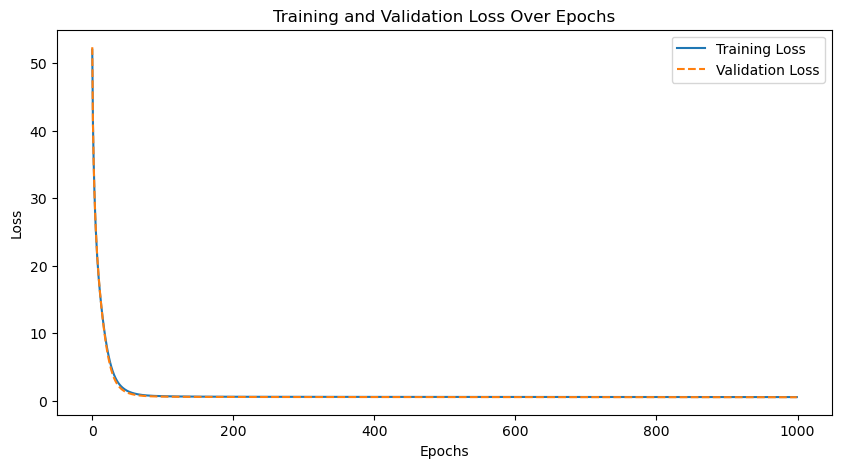

In [10]:
# Define the features we want to keep
# Keep only pickup and drop off positions
features_model1 = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

# Split 10% of the training data as validation set
model1_x = select_features(X_train, features_model1)
model1_y = y_train
model1_x_train, model1_x_val, model1_y_train, model1_y_val = train_test_split(model1_x, model1_y, test_size=0.1, random_state=0)
model1_x_test = select_features(X_test, features_model1)

# Define Model
model1 = Sequential()
model1.add(LinearLayer(model1_x_train.shape[1], 4))
model1.add(ReLU())
model1.add(LinearLayer(4, 4))
model1.add(ReLU())
model1.add(LinearLayer(4, 1))

# Training Setup
epochs_model1 = 1000
learning_rate_model1 = 0.01
loss_function_model1 = MeanSquaredErrorLoss()

best_loss_model1 = float("inf")
patience_model1 = 3  # Early stopping patience
stagnation_model1 = 0
losses_model1 = []
val_losses_model1 = []

for epoch_model1 in range(epochs_model1):
    predictions_model1 = model1.forward(model1_x_train)
    loss_model1 = loss_function_model1.forward(predictions_model1, model1_y_train)
    losses_model1.append(loss_model1)
    
    val_predictions_model1 = model1.forward(model1_x_val)
    val_loss_model1 = loss_function_model1.forward(val_predictions_model1, model1_y_val)
    val_losses_model1.append(val_loss_model1)
    
    print(f"Epoch {epoch_model1}, Loss: {loss_model1:.4f}, Val Loss: {val_loss_model1:.4f}")
    
    grad_output_model1 = loss_function_model1.backward()
    model1.backward(grad_output_model1, learning_rate_model1)

    # Early stopping
    if loss_model1 < best_loss_model1:
        best_loss_model1 = loss_model1
        stagnation_model1 = 0
        print(f"Saving model at epoch {epoch_model1} with loss {loss_model1:.4f}")
        model1.save_weights("best_model1")
    else:
        stagnation_model1 += 1
        if stagnation_model1 >= patience_model1:
            print("Early stopping triggered.")
            break

# Load best model and evaluate on test set
test_predictions_model1 = model1.forward(model1_x_test)
test_loss_model1 = loss_function_model1.forward(test_predictions_model1, y_test)
print(f"Test Loss (MSE): {test_loss_model1:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(losses_model1, label='Training Loss')
plt.plot(val_losses_model1, label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


### Pickup Time, Position and Dropoff Time, Position

In [ ]:
# Define the features we want to keep
# Keep only pickup and drop off positions, and add pickup and dropoff month, day, hour
features_model2 = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude",
                   "pickup_month", "pickup_day", "pickup_hour", "dropoff_month", "dropoff_day", "dropoff_hour"]

# Split 10% of the training data as validation set
model2_x = select_features(X_train, features_model2)
model2_y = y_train
model2_x_train, model2_x_val, model2_y_train, model2_y_val = train_test_split(model2_x, model2_y, test_size=0.1, random_state=0)
model2_x_test = select_features(X_test, features_model2)

# Define Model
model2 = Sequential()
model2.add(LinearLayer(model2_x_train.shape[1], 4))
model2.add(ReLU())
model2.add(LinearLayer(4, 10))
model2.add(ReLU())
model2.add(LinearLayer(10, 1))

# Training Setup
epochs_model2 = 1000
learning_rate_model2 = 0.01
loss_function_model2 = MeanSquaredErrorLoss()

best_loss_model2 = float("inf")
patience_model2 = 3  # Early stopping patience
stagnation_model2 = 0
losses_model2 = []
val_losses_model2 = []

for epoch_model2 in range(epochs_model2):
    predictions_model2 = model2.forward(model2_x_train)
    loss_model2 = loss_function_model2.forward(predictions_model2, model2_y_train)
    losses_model2.append(loss_model2)
    
    val_predictions_model2 = model2.forward(model2_x_val)
    val_loss_model2 = loss_function_model2.forward(val_predictions_model2, model2_y_val)
    val_losses_model2.append(val_loss_model2)
    
    print(f"Epoch {epoch_model2}, Loss: {loss_model2:.4f}, Val Loss: {val_loss_model2:.4f}")
    
    grad_output_model2 = loss_function_model2.backward()
    model2.backward(grad_output_model2, learning_rate_model2)

    # Early stopping
    if loss_model2 < best_loss_model2:
        best_loss_model2 = loss_model2
        stagnation_model2 = 0
        print(f"Saving model at epoch {epoch_model2} with loss {loss_model2:.4f}")
        model2.save_weights("best_model2")
    else:
        stagnation_model2 += 1
        if stagnation_model2 >= patience_model2:
            print("Early stopping triggered.")
            break

# Load best model and evaluate on test set
test_predictions_model2 = model2.forward(model2_x_test)
test_loss_model2 = loss_function_model2.forward(test_predictions_model2, y_test)
print(f"Test Loss (MSE): {test_loss_model2:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(losses_model2, label='Training Loss')
plt.plot(val_losses_model2, label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()



First row of training data
pickup_longitude    -0.097814
pickup_latitude     -0.177093
dropoff_longitude    0.373522
dropoff_latitude     0.603241
pickup_month        -0.307333
pickup_day          -1.322026
pickup_hour         -0.407245
dropoff_month       -0.307514
dropoff_day         -1.322092
dropoff_hour        -0.400892
Name: 48499, dtype: float64
[[-5.66564209e-02  7.17088848e+00]
 [ 3.83014950e-02  6.81563999e+00]
 [ 3.26004595e-02  6.84161548e+00]
 ...
 [ 3.35620023e-02  6.42648846e+00]
 [ 2.16942740e-03  5.24174702e+00]
 [ 1.95304241e-02  6.77764659e+00]]
[[ 1.03414219e-01  6.42486902e+00]
 [-8.26705145e-02  7.35244110e+00]
 [ 4.46158822e-03  7.28000825e+00]
 ...
 [ 9.38266230e-02  6.79122146e+00]
 [-3.12387201e-03  6.11146734e+00]
 [-9.47994215e-01  5.76832100e+00]]
Epoch 0, Loss: 43.4378, Val Loss: 43.6324
Saving model at epoch 0 with loss 43.4378
[[0.98982552 7.17088848]
 [2.57970533 6.81563999]
 [0.52199105 6.84161548]
 ...
 [2.52985271 6.42648846]
 [0.18533443 5.24174702

### Pickup Time, Position and Dropoff Time, Position and day of the week

[[0.06434138 7.17088848]
 [0.83169481 6.81563999]
 [0.62809102 6.84161548]
 ...
 [0.39328636 6.42648846]
 [0.31639395 5.24174702]
 [0.59439923 6.77764659]]
[[0.86800179 6.42486902]
 [1.24483829 7.3524411 ]
 [0.22497904 7.28000825]
 ...
 [0.91231513 6.79122146]
 [1.21762668 6.11146734]
 [0.01836923 5.768321  ]]
Epoch 0, Loss: 31.8480, Val Loss: 31.7364
Saving model at epoch 0 with loss 31.8480
[[0.3472842  7.17088848]
 [1.5863802  6.81563999]
 [1.04680348 6.84161548]
 ...
 [0.70065122 6.42648846]
 [0.50994403 5.24174702]
 [1.01406116 6.77764659]]
[[1.43689963 6.42486902]
 [1.96540529 7.3524411 ]
 [0.45646768 7.28000825]
 ...
 [1.32798388 6.79122146]
 [2.03964563 6.11146734]
 [0.18947234 5.768321  ]]
Epoch 1, Loss: 26.5976, Val Loss: 26.4379
Saving model at epoch 1 with loss 26.5976
[[0.7045908  7.17088848]
 [2.45078997 6.81563999]
 [1.50476787 6.84161548]
 ...
 [1.03670653 6.42648846]
 [0.70756828 5.24174702]
 [1.4756979  6.77764659]]
[[2.0562172  6.42486902]
 [2.77888939 7.3524411 ]
 [

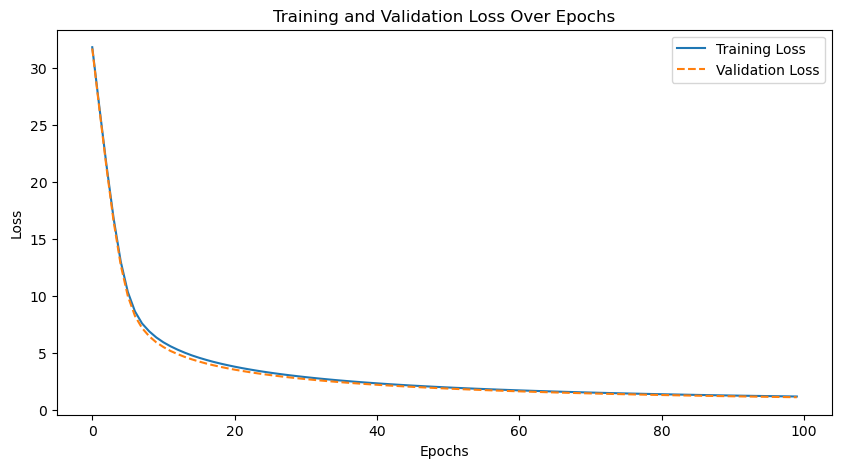

In [6]:
# Define the features we want to keep
# Keep only pickup and drop off positions, and add pickup and dropoff month, day, hour, and day of week
features_model3 = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude",
                   "pickup_month", "pickup_day", "pickup_hour", "dropoff_month", "dropoff_day", "dropoff_hour", 
                   "pickup_day_of_week", "dropoff_day_of_week"]

# Split 10% of the training data as validation set
model3_x = select_features(X_train, features_model3)
model3_y = y_train
model3_x_train, model3_x_val, model3_y_train, model3_y_val = train_test_split(model3_x, model3_y, test_size=0.1, random_state=0)
model3_x_test = select_features(X_test, features_model3)

# Define Model
model3 = Sequential()
model3.add(LinearLayer(model3_x_train.shape[1], 12))
model3.add(ReLU())
model3.add(LinearLayer(12, 12))
model3.add(ReLU())
model3.add(LinearLayer(12, 1))

# Training Setup
epochs_model3 = 1000
learning_rate_model3 = 0.01
loss_function_model3 = MeanSquaredErrorLoss()

best_loss_model3 = float("inf")
patience_model3 = 3  # Early stopping patience
stagnation_model3 = 0
losses_model3 = []
val_losses_model3 = []

for epoch_model3 in range(epochs_model3):
    predictions_model3 = model3.forward(model3_x_train)
    loss_model3 = loss_function_model3.forward(predictions_model3, model3_y_train)
    losses_model3.append(loss_model3)
    
    val_predictions_model3 = model3.forward(model3_x_val)
    val_loss_model3 = loss_function_model3.forward(val_predictions_model3, model3_y_val)
    val_losses_model3.append(val_loss_model3)
    
    print(f"Epoch {epoch_model3}, Loss: {loss_model3:.4f}, Val Loss: {val_loss_model3:.4f}")
    
    grad_output_model3 = loss_function_model3.backward()
    model3.backward(grad_output_model3, learning_rate_model3)

    # Early stopping
    if loss_model3 < best_loss_model3:
        best_loss_model3 = loss_model3
        stagnation_model3 = 0
        print(f"Saving model at epoch {epoch_model3} with loss {loss_model3:.4f}")
        model3.save_weights("best_model3")
    else:
        stagnation_model3 += 1
        if stagnation_model3 >= patience_model3:
            print("Early stopping triggered.")
            break

# Load best model and evaluate on test set
test_predictions_model3 = model3.forward(model3_x_test)
test_loss_model3 = loss_function_model3.forward(test_predictions_model3, y_test)
print(f"Test Loss (MSE): {test_loss_model3:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(losses_model3, label='Training Loss')
plt.plot(val_losses_model3, label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()
